In [146]:
!pip install datasets #Only for colab

In [147]:
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Extract test, train and validation datasets
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
valid_df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])
test_df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

In [148]:
print(train_df)
print(valid_df)
print(test_df)

                                                    text  label
0                                i didnt feel humiliated      0
1      i can go from feeling so hopeless to so damned...      0
2       im grabbing a minute to post i feel greedy wrong      3
3      i am ever feeling nostalgic about the fireplac...      2
4                                   i am feeling grouchy      3
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[16000 rows x 2 columns]
                                                   text  label
0     im feeling quite sad and sorry for myself but ...      0
1     i feel like i am still looking at a blank canv...      0
2                

In [149]:

# Split into training and validation datasets
train_texts = train_df['text']
train_labels = train_df['label']

val_texts = valid_df['text']
val_labels = valid_df['label']

test_texts = test_df['text']
test_labels = test_df['label']

print(len(train_texts))
print(len(val_texts))

# Tokenize the texts
max_features = 10000  # Adjust this based on your use case
tokenizer = Tokenizer(num_words=max_features, oov_token="Word Out of Vocab")
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Pad sequences to the same length
max_length = 1000  # Adjust this based on your dataset
train_data = pad_sequences(train_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)
val_data = pad_sequences(val_sequences, maxlen=max_length)



# Convert labels to categorical (if necessary)
num_classes = len(set(train_labels))
train_labels = np.array(to_categorical(train_labels, num_classes=num_classes))
test_labels = np.array(to_categorical(test_labels, num_classes=num_classes))
val_labels = np.array(to_categorical(val_labels, num_classes=num_classes))

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(val_data.shape)
print(val_labels.shape)



16000
2000
(16000, 1000)
(16000, 6)
(2000, 1000)
(2000, 6)
(2000, 1000)
(2000, 6)


In [150]:

train_data = pad_sequences(train_data, maxlen=200, padding='post')
test_data = pad_sequences(test_data, maxlen=200, padding='post')
val_data = pad_sequences(val_data, maxlen=200, padding='post')

In [151]:
# Display the third movie review
print('Shape of the third padded review:', train_data[2].shape, '\n')
print(train_data[2])

Shape of the third padded review: (200,) 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    

#NLP with Bidirectional LSTM

Illya Gordyy




In [152]:
# Create a model
embedding_dim = 100
model = tf.keras.Sequential([
       tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_length),
       # add some RNN layers if you prefer
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(6, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [153]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


In [154]:


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)

history = model.fit(
    train_data,
    train_labels,
    validation_data = (val_data, val_labels),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping])

(16000, 200)
(16000, 6)
(2000, 200)
(2000, 6)
Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3330 - loss: 1.6410 - val_accuracy: 0.5955 - val_loss: 1.0621
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6316 - loss: 0.9911 - val_accuracy: 0.7550 - val_loss: 0.7108
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7720 - loss: 0.6306 - val_accuracy: 0.8320 - val_loss: 0.5446
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8743 - loss: 0.4021 - val_accuracy: 0.8470 - val_loss: 0.4873
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9075 - loss: 0.2886 - val_accuracy: 0.8860 - val_loss: 0.3976
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9224 - loss: 0.2190 - val_accuracy: 0.8990 - val_loss: 0.3675
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9433 - loss: 0.1651 - val_accuracy: 0.9065 - val_loss: 0.3823
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [155]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9217 - loss: 0.3014
Test Loss: 0.3008647859096527
Test Accuracy: 0.9190000295639038


In [156]:
actual_labels = np.argmax(test_labels, axis=1)  # Convert one-hot encoded to class indices
predicted_labels = np.argmax(model.predict(test_data), axis=1)  # Predictions
cm = confusion_matrix(actual_labels, predicted_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


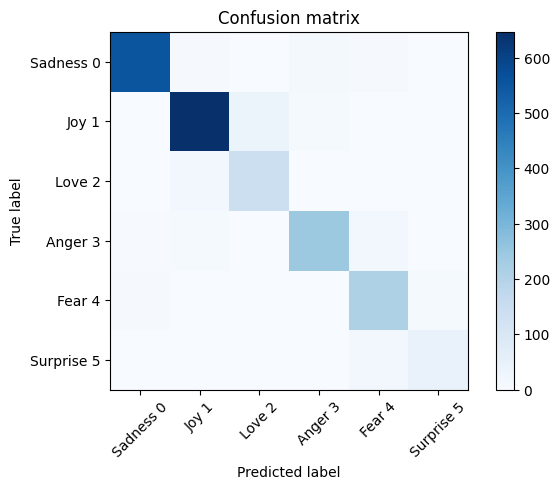

In [157]:

# Define class names
class_names = ["Sadness 0", "Joy 1", "Love 2", "Anger 3", "Fear 4", "Surprise 5"]

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)


In [158]:



report = classification_report(actual_labels, predicted_labels, target_names=["Sadness 0", "Joy 1", "Love 2", "Anger 3", "Fear 4", "Surprise 5"])
print(report)


              precision    recall  f1-score   support

   Sadness 0       0.97      0.96      0.96       581
       Joy 1       0.95      0.93      0.94       695
      Love 2       0.80      0.88      0.84       159
     Anger 3       0.91      0.89      0.90       275
      Fear 4       0.84      0.93      0.88       224
  Surprise 5       0.81      0.67      0.73        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.92      0.92      0.92      2000



In [159]:
# Define contraction mappings
contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how does",
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", " u ": " you ", " ur ": " your ", " n ": " and "
}

In [160]:
import re
import pandas as pd
# Define function to clean text
def get_clean_text(x):
    if type(x) is str:
        x = x.lower()
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        x = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', x)  # Remove emails
        x = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x)  # Remove URLs
        x = re.sub('RT', "", x)  # Remove retweet (RT) prefix
        x = re.sub('[^A-Z a-z]+', '', x)  # Remove non-alphabetic characters
        return x
    else:
        return x


# Function to expand contractions
def expand_contractions(text):
    # Function to replace contractions based on the dictionary
    def replace_contraction(match):
        return contractions[match.group(0)]

    # Create a regex pattern that matches any contraction
    contraction_pattern = re.compile(r'\b(?:' + '|'.join(contractions.keys()) + r')\b')

    # Replace contractions in the text
    return re.sub(contraction_pattern, replace_contraction, text)


# Example usage
sample_text = "I can't believe it's already 5 o'clock, I ain't going anywhere."
expanded_text = expand_contractions(sample_text)
print(f"Original: {sample_text}")
print(f"Expanded: {expanded_text}")

Original: I can't believe it's already 5 o'clock, I ain't going anywhere.
Expanded: I cannot believe it is already 5 of the clock, I am not going anywhere.


In [161]:
# Split into training and validation datasets
train_texts = train_df['text']
train_labels = train_df['label']

val_texts = valid_df['text']
val_labels = valid_df['label']

test_texts = test_df['text']
test_labels = test_df['label']

print(len(train_texts))
print(len(val_texts))

train_texts = train_df['text'].apply(lambda x: get_clean_text(expand_contractions(x)))
val_texts = valid_df['text'].apply(lambda x: get_clean_text(expand_contractions(x)))
test_texts = test_df['text'].apply(lambda x: get_clean_text(expand_contractions(x)))

# Tokenize the texts
max_features = 10000  # Adjust this based on your use case
tokenizer = Tokenizer(num_words=max_features, oov_token="Word Out of Vocab")
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Pad sequences to the same length
max_length = 500  # Adjust this based on your dataset
train_data = pad_sequences(train_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)
val_data = pad_sequences(val_sequences, maxlen=max_length)



# Convert labels to categorical (if necessary)
num_classes = len(set(train_labels))
train_labels = np.array(to_categorical(train_labels, num_classes=num_classes))
test_labels = np.array(to_categorical(test_labels, num_classes=num_classes))
val_labels = np.array(to_categorical(val_labels, num_classes=num_classes))

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(val_data.shape)
print(val_labels.shape)


16000
2000
(16000, 500)
(16000, 6)
(2000, 500)
(2000, 6)
(2000, 500)
(2000, 6)


In [162]:
token = Tokenizer()
token.fit_on_texts(train_texts)

In [163]:
vocab_size  = len(token.word_index) + 1
vocab_size

15212

In [164]:
encoded_text = token.texts_to_sequences(train_texts)

In [165]:
print(encoded_text[:3])

[[1, 138, 2, 678], [1, 39, 100, 59, 7, 14, 493, 4, 14, 3493, 552, 31, 59, 60, 127, 147, 75, 1478, 3, 21, 1253], [16, 3057, 6, 1147, 4, 285, 1, 2, 494, 437]]


In [166]:
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [167]:
print(X)
X.shape

[[   1  138    2 ...    0    0    0]
 [   1   39  100 ...    0    0    0]
 [  16 3057    6 ...    0    0    0]
 ...
 [   1    2  326 ...    0    0    0]
 [   1    2   13 ...    0    0    0]
 [   1   46    6 ...    0    0    0]]


(16000, 500)

In [168]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
glove_vectors = dict()

In [170]:
file = open('/content/glove.twitter.27B.100d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1: ])
    glove_vectors[word] = vectors
file.close()

In [171]:
glove_vectors.get('thisisaOOVword')

In [172]:
glove_vectors.get('you').shape

(100,)

In [173]:
word_vector_matrix = np.zeros((vocab_size, 100))

tokens = []
labels = []

for word, index in token.word_index.items():   # index returned here starts with 1 so we need set vocab_size = len(token.word_index) + 1  to be able to index up to the greatest token ID
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector

        #for plotting
        tokens.append(word_vector_matrix[index])
        labels.append(word)

    else:
        print(word)


pagetitle
twinges
siwons
percieve
vbac
undesired
amvassago
adomen
unza
complainy
unfurling
regimented
custodes
aryiku
shinae
gunong
creaminess
haircute
constructivism
yomis
lenghth
jacynthe
gerling
supportiveness
dwelled
dannika
wryly
hyperchondria
bloging
artifically
manitz
enjambment
educationg
gosman
cawing
pilings
sympathic
perishables
wheeeeee
uplifter
suicidalness
dykey
provokingbeauty
arrangment
beared
honkerblonked
saturating
instructables
suominen
pileon
kamiki
nonchan
unrewarding
beaubronz
docrat
allthingsbucks
irresponcible
belongingness
carby
isprivate
ismobile
mobileclass
isprivateblog
languagedirection
feedlinks
inbalance
aahhh
muffling
nowwwwww
whitleys
forelorn
baachan
covingtons
loudons
mcgarrigle
snotface
endeavoring
nagalene
stellarium
zendikar
lobia
bqff
judeo
missgivings
elihu
proplems
uncomposed
tiphany
covetousnes
terpene
leadingstrings
hakodesh
myelf
mehow
coinfections
herrman
haptics
chocolating
squelching
struff
fedtastic
incrementally
vineman
fulsome
intermar

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(500, 2)


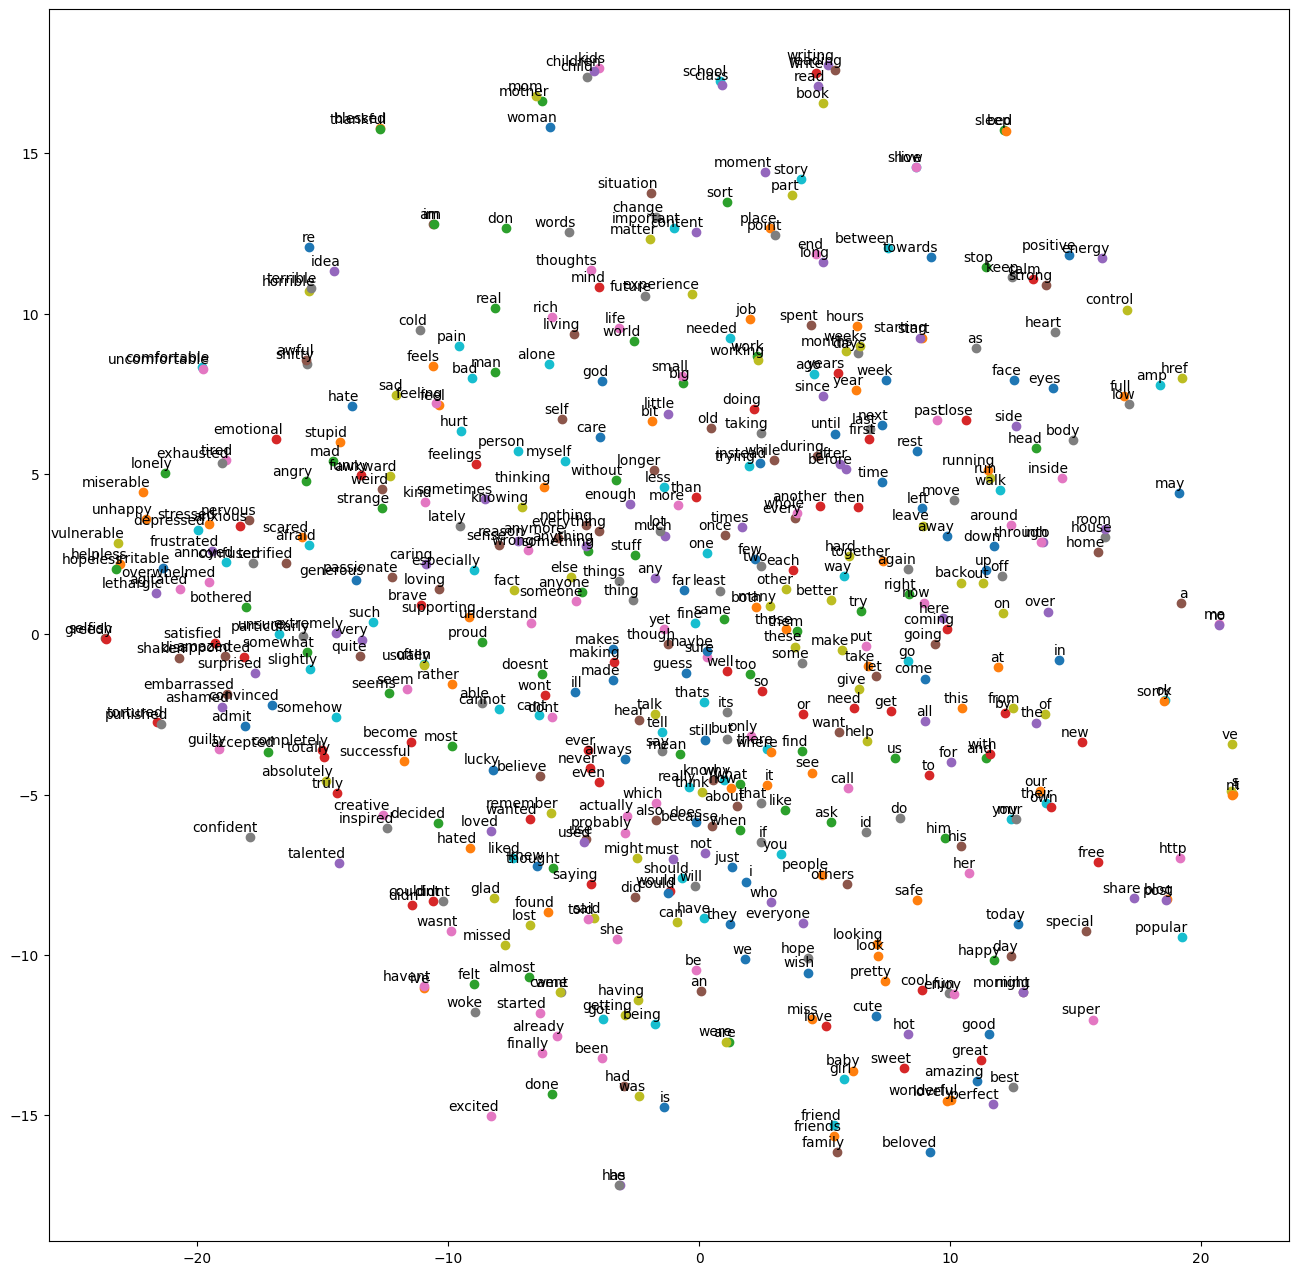

In [174]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne(tokens=tokens):

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tokens = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens[:500])
    print(new_values.shape)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16,16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


tsne(tokens)

In [175]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(val_data.shape)
print(val_labels.shape)

print(vocab_size)
print(vec_size)


(16000, 500)
(16000, 6)
(2000, 500)
(2000, 6)
(2000, 500)
(2000, 6)
15212
100


#NLP with Glove

Danny and Illya

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10,        # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore model weights from the epoch with the best validation loss
)

vec_size = 100

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = vec_size, input_length=max_length, weights = [word_vector_matrix], trainable = False))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=500, return_sequences=True)))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=200)))

# Add a dense output layer
model.add(Dense(units=100))

# Add a dense output layer
model.add(Dense(units=6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_data, train_labels, epochs = 100, validation_data = (val_data, val_labels), callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.3261 - loss: 1.5946 - val_accuracy: 0.3555 - val_loss: 1.5568
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.3538 - loss: 1.5830 - val_accuracy: 0.3625 - val_loss: 1.5452
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.3794 - loss: 1.5255 - val_accuracy: 0.4110 - val_loss: 1.4731
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.4695 - loss: 1.3612 - val_accuracy: 0.7525 - val_loss: 0.6985
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.8042 - loss: 0.5474 - val_accuracy: 0.8855 - val_loss: 0.3214
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.9206 - loss: 0.2105 - val_accuracy: 0.9065 - val_loss: 0.2538
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.9478 - loss: 0.1249 - val_accuracy: 0.9135 - val_loss: 0.2185
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.9603 - loss: 0.0942 - val_

In [177]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9057 - loss: 0.2238
Test Loss: 0.23063892126083374
Test Accuracy: 0.9035000205039978


In [178]:
actual_labels = np.argmax(test_labels, axis=1)  # Convert one-hot encoded to class indices
predicted_labels = np.argmax(model.predict(test_data), axis=1)  # Predictions
cm = confusion_matrix(actual_labels, predicted_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


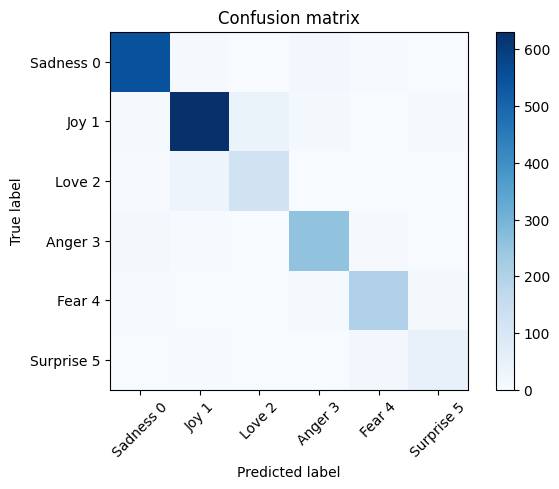

In [179]:

# Define class names
class_names = ["Sadness 0", "Joy 1", "Love 2", "Anger 3", "Fear 4", "Surprise 5"]

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)


In [180]:
report = classification_report(actual_labels, predicted_labels, target_names=["Sadness 0", "Joy 1", "Love 2", "Anger 3", "Fear 4", "Surprise 5"])
print(report)


              precision    recall  f1-score   support

   Sadness 0       0.96      0.95      0.95       581
       Joy 1       0.93      0.91      0.92       695
      Love 2       0.75      0.77      0.76       159
     Anger 3       0.86      0.93      0.89       275
      Fear 4       0.89      0.90      0.89       224
  Surprise 5       0.75      0.70      0.72        66

    accuracy                           0.90      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.90      0.90      0.90      2000

